Plot the outcome of simulations exploring the role of $\beta$ in the magnetisation markup on the Pokec social network.

Created on: 10/02/21

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib
import pylab
import itertools

In [2]:
eval_data=pd.read_csv('Data/Pokec_control_eval_as_beta')
print(sorted(list(set(eval_data['beta_factor'].to_list()))))

[0.1, 0.17969891485325942, 0.32291699999438983, 0.5802783448666183, 1.0427538888537675, 1.873817422860383, 3.3672295752114207, 6.050875007272942, 10.873356727196558, 19.539304046896085, 35.11191734215127, 63.095734448019336]


In [3]:
# eval_data=pd.read_csv("Data/Pokec_control_eval_data_g5_beta_impact.csv")
eval_data=pd.read_csv('Data/Pokec_control_eval_as_beta')
# eval_data=pd.read_csv("Data/Pokec_control_eval_data_g0_beta_impact_w_full.csv").append(pd.read_csv("Data/Pokec_control_eval_data_g0_beta_impact_w_full_2.csv"))

eval_data=eval_data.loc[eval_data['beta_factor']<20.0]

In [4]:
control_names = list(set(eval_data['control'].to_list())-set(['unif'])) #['block','full','nc','sv','snapshot']
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif']

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

,beta_factor__,gradient__,markup_block_mean,markup_block_sem,markup_full_mean,markup_full_sem
0,0.100000,0.0,-0.001585,0.001989,-0.000957,0.002114
1,0.179699,0.0,-0.002467,0.001099,-0.001128,0.001229
2,0.322917,0.0,0.000544,0.002080,0.000751,0.002367
3,0.580278,0.0,0.001151,0.002094,0.000935,0.002216
4,1.042754,0.0,0.003036,0.003149,0.010088,0.002920


## Plot average magnetisation

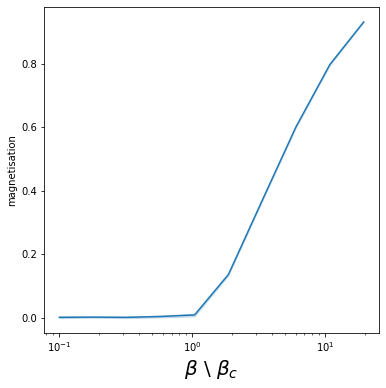

In [5]:
fig,ax=plt.subplots(figsize=(6,6))
just_unif=eval_data.loc[eval_data['control']=='unif']
sns.lineplot(data=just_unif,x='beta_factor',y='magnetisation')
plt.xlabel("$\\beta$ \ $\\beta_c $",fontsize=20)
plt.xscale('log')

## Plot markup and average magnetisation

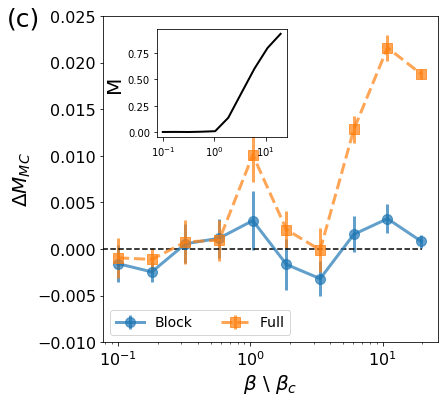

In [6]:
gradient = list(grouped['beta_factor__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([0,20],[0,0],'k--')

plt.xlabel("$\\beta$ \ $\\beta_c $",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')
ax.legend(fontsize=14,ncol=2,loc='lower left').set_zorder(0)
#plt.xlim(0.001,5)
#plt.xlim(0,3)

#plt.ylim(-0.015,0.01)
plt.xscale('log')
plt.ylim(-0.01,0.025)

plt.text(0.0145,0.024,'(c)',fontsize=25)

#Inset to show the magnetisation.
left, bottom, width, height = [0.25, 0.6, 0.3, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
just_unif_means=just_unif.groupby(['beta_factor']).agg({'magnetisation':np.mean}).reset_index()
mag_vals=just_unif_means['magnetisation'].to_list()
beta_vals_unif=just_unif_means['beta_factor'].to_list()
ax2.plot(beta_vals_unif,mag_vals,lw=2.0,color='k')
ax2.set_xscale('log')
ax2.set_xticks([0.1,1,10],['10','10','10'])
ax2.set_ylabel("M",fontsize=20,rotation=90)



plt.savefig("Plots/markup_as_beta_grad_0_postivie.jpg",bbox_inches='tight')

## Fractional markup

Also compute in terms of the change in the vote share.

In [7]:
eval_data['percent_up']= (eval_data['magnetisation']+1.0)/2.0
eval_data

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient,Sample_index,percent_up
0,0,block,-0.003374,0.000017,0.100000,0.0,1,0.498313
1,1,unif,-0.004628,0.000024,0.100000,0.0,1,0.497686
2,2,full,0.001167,0.000013,0.100000,0.0,1,0.500584
3,0,block,-0.004128,0.000016,0.100000,0.0,2,0.497936
4,1,unif,-0.004330,0.000034,0.100000,0.0,2,0.497835
...,...,...,...,...,...,...,...,...
445,1,unif,0.934344,0.000003,19.539304,0.0,14,0.967172
446,2,full,0.951424,0.000006,19.539304,0.0,14,0.975712
447,0,block,0.933817,0.000006,19.539304,0.0,15,0.966908
448,1,unif,0.931682,0.000003,19.539304,0.0,15,0.965841


(0.45, 0.6)

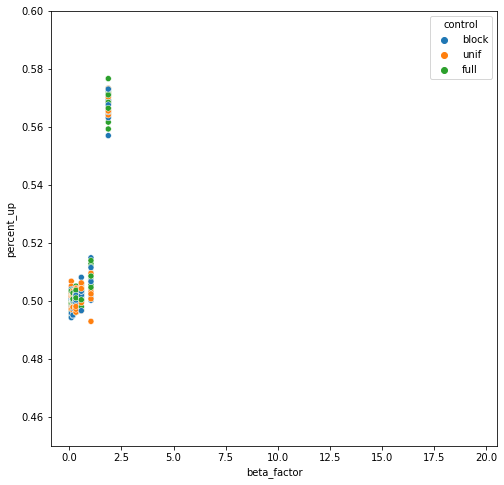

In [8]:
# Plotting raw magnetisations helps to illustrate behaviour of mag
fig,ax=plt.subplots(figsize=(8,8))
sns.scatterplot(data=eval_data,x='beta_factor',y='percent_up',hue='control')
#sns.lineplot(data=eval_data,x='beta_factor',y='magnetisation',hue='control')
#plt.xscale('log')
#plt.xlim(0.01,5.0)
#plt.ylim(-0.05,0.2)

plt.ylim(0.45,0.6)
#plt.xlim(0.9,2.1)

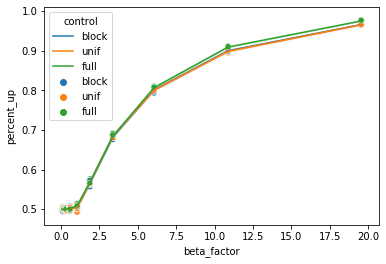

In [9]:
sns.lineplot(data=eval_data,x='beta_factor',y='percent_up',hue='control')
sns.scatterplot(data=eval_data,x='beta_factor',y='percent_up',hue='control')
#plt.ylim(0.45,0.6)
#plt.xlim(0.9,2.1)